In [ ]:
# import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [62]:
class LogisticRegression():
    def __init__(self, should_normalize=True, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.should_normalize = should_normalize
        self.mean = None
        self.std = None

    def fit(self, X, y):
        # Initialize parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Normalize the data and store normalization parameters
        X_normalized = self.normalize_fit(X)
        
        # Training loop
        for i in range(self.n_iters):
            # Forward pass
            y_pred = self.predict(X_normalized)
            
            # Compute loss
            loss = self.compute_loss(y, y_pred)
            
            # Compute gradients
            dw, db = self.gradient_descent(X_normalized, y, y_pred, n_samples)
            
            # Update weights
            self.update_weights(dw, db)
            
            # Print progress every 100 iterations
            if i % 100 == 0:
                print(f"Iteration {i+1}, Loss: {loss:.4f}")

    def normalize_fit(self, X):
        """Fit normalization parameters and transform X"""
        if self.should_normalize == False:
            return X
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        # Avoid division by zero
        self.std = np.where(self.std == 0, 1, self.std)
        return (X - self.mean) / self.std

    def normalize_transform(self, X):
        """Transform X using fitted normalization parameters"""
        if self.should_normalize == False:
            return X
        return (X - self.mean) / self.std

    def sigmoid(self, z):
        # Clip z to prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def compute_loss(self, y, y_pred):
        # Add small epsilon to prevent log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return np.mean(loss)
    
    def gradient_descent(self, X, y, y_pred, m):
        # Compute gradients using matrix multiplication
        dw = np.dot(X.T, (y_pred - y)) / m
        db = np.sum(y_pred - y) / m
        return dw, db
    
    def update_weights(self, dw, db):
        self.weights -= self.lr * dw
        self.bias -= self.lr * db
    
    def predict_class(self, X):
        # Normalize X using the same parameters as training
        X_normalized = self.normalize_transform(X)
        y_pred = self.predict(X_normalized)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [63]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("abineshpa/spam-email-dataset")

# print("Path to dataset files:", path)

In [64]:
path_to_dataset = r'C:\Users\tahan\.cache\kagglehub\datasets\abineshpa\spam-email-dataset\versions\1\emails.csv'

dataset = pd.read_csv(path_to_dataset)

In [65]:
dataset.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:

# Utitlity functions for pre-processing

# I just do little bit pre-processing, but you can definitily use your own pre-processing functions, other methods and improve it. My goas here is just to use the logisitic regression model thate we build from scratch. But if you will look at the results, they are insane.

stop_words = set(stopwords.words('english'))
filler_words = {'um', 'uh', 'like', 'you know', 'i mean', 'so', 'actually', 'basically'}


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    cleaned = [word for word in tokens if word not in stop_words and word not in filler_words]
    return ' '.join(cleaned)


def get_normalized_text(dataset):
    dataset['text'] = dataset['text'].apply(lambda x: x.lower())
    dataset['text'] = dataset['text'].apply(lambda x: x.replace('\n', ' '))
    dataset['text'] = dataset['text'].apply(lambda x: x.replace('\r', ' '))
    dataset['text'] = dataset['text'].apply(lambda x: x.replace('\t', ' '))
    dataset['text'] = dataset['text'].apply(lambda x: x.replace('  ', ' '))
    dataset['text'] = dataset['text'].apply(preprocess_text)

get_normalized_text(dataset)



In [ ]:

# Create embedding using Tf-Idf. We can also use some other optins like word2vec etc.

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(dataset['text'])
y = dataset['spam']

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

X_train = X_train.toarray()
X_test = X_test.toarray()



In [69]:
logistic_regress = LogisticRegression(should_normalize=True, lr=0.01, n_iters=1000)

In [70]:
logistic_regress.fit(X_train, y_train)

Iteration 1, Loss: 0.6931
Iteration 101, Loss: 0.1204
Iteration 201, Loss: 0.0656
Iteration 301, Loss: 0.0446
Iteration 401, Loss: 0.0337
Iteration 501, Loss: 0.0270
Iteration 601, Loss: 0.0226
Iteration 701, Loss: 0.0193
Iteration 801, Loss: 0.0169
Iteration 901, Loss: 0.0150


In [ ]:
y_pred_classes = logistic_regress.predict_class(X_test)
print(f"Predicted classes: {y_pred_classes[:10]}")
print(f"Actual classes: {list(y_test)[:10]}") 

accuracy = np.mean(y_pred_classes == y_test)
print(f"Accuracy: {accuracy:.4f}")



Predicted classes: [0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Actual classes: [0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Accuracy: 0.9808


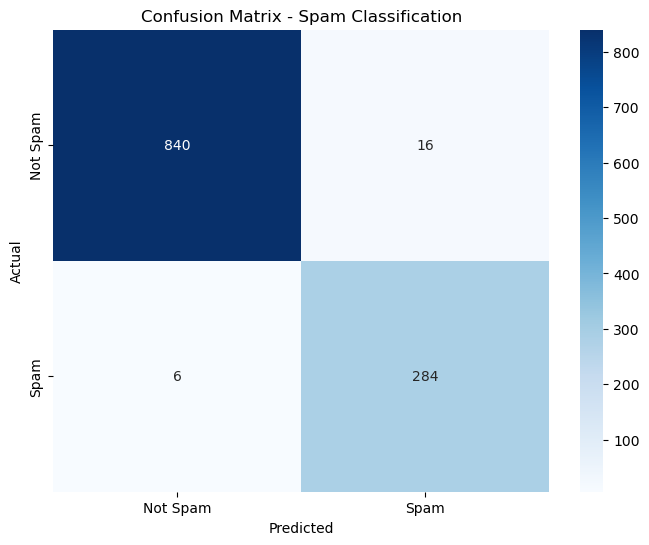


Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.99      0.98      0.99       856
        Spam       0.95      0.98      0.96       290

    accuracy                           0.98      1146
   macro avg       0.97      0.98      0.97      1146
weighted avg       0.98      0.98      0.98      1146



In [72]:
# Import additional libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Spam', 'Spam'], 
            yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix - Spam Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Not Spam', 'Spam']))


In [74]:
# Test the model on some sample emails
sample_emails = [
    "Congratulations! You've won a free iPhone! Click here to claim your prize now!",
    "Hi John, let's meet for lunch tomorrow at 12 PM. How does that sound?",
    "URGENT: Your account will be closed unless you verify your information immediately!",
    "The meeting has been rescheduled to 3 PM on Friday. Please confirm your attendance.",
    "Get rich quick! Make $1000 a day working from home! No experience needed!",
    "Your email has been randomly selected in the Global Lottery Draw. You have won $1,000,000 USD! To claim your prize, simply reply with your full name, address, and bank details. Act fast! This offer expires in 24 hours.",
    "We noticed suspicious activity on your account. For your safety, your account has been temporarily suspended. Please click the link below and verify your information immediately: [http://fake-bank-login.com](http://fake-bank-login.com) Failure to do so will result in permanent suspension."
]

print("Testing on sample emails:\n")
for i, email in enumerate(sample_emails):
    # Preprocess the email
    processed_email = preprocess_text(email)
    
    # Transform using the same vectorizer
    email_tfidf = vectorizer.transform([processed_email]).toarray()
    
    # Make prediction
    prediction = logistic_regress.predict_class(email_tfidf)[0]
    spam_label = "SPAM" if prediction == 1 else "NOT SPAM"
    
    print(f"Email {i+1}: {email[:50]}...")
    print(f"Prediction: {spam_label}")
    print("-" * 60)


Testing on sample emails:

Email 1: Congratulations! You've won a free iPhone! Click h...
Prediction: SPAM
------------------------------------------------------------
Email 2: Hi John, let's meet for lunch tomorrow at 12 PM. H...
Prediction: NOT SPAM
------------------------------------------------------------
Email 3: URGENT: Your account will be closed unless you ver...
Prediction: NOT SPAM
------------------------------------------------------------
Email 4: The meeting has been rescheduled to 3 PM on Friday...
Prediction: NOT SPAM
------------------------------------------------------------
Email 5: Get rich quick! Make $1000 a day working from home...
Prediction: SPAM
------------------------------------------------------------
Email 6: Your email has been randomly selected in the Globa...
Prediction: SPAM
------------------------------------------------------------
Email 7: We noticed suspicious activity on your account. Fo...
Prediction: SPAM
-----------------------------------